<a href="https://colab.research.google.com/github/jd-13/progan-intro/blob/master/ProGAN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

*(This notebook is based on work published in this repo: https://github.com/tkarras/progressive_growing_of_gans)*

In 2018 Nivida published a Generative Adversarial Network (GAN) which had been trained "progressively" and produced much higher quality images than had previously been achieved.

The images below are an example output handpicked by the team which published the work.

![](https://raw.githubusercontent.com/tkarras/progressive_growing_of_gans/master/representative_image_512x256.png)

Training a GAN "progressively" refers to a technique which trains the generator and discriminator of the GAN on low resolution images initially, and then progresses to increasingly high resolution images during the training process. The model we'll be looking at was trained on the CelebA dataset, which is a dataset of celebrity portrait images.

Training the ProGAN network that was published by Nvidia requires significant compute resources, so this notebook will just be a simple introduction to generating images from a pretrained ProGAN.




# Install dependencies

First we need to clone the github repo containing most of the work, and install PyDrive.

In [0]:
!git clone https://github.com/tkarras/progressive_growing_of_gans.git
!pip install PyDrive

fatal: destination path 'progressive_growing_of_gans' already exists and is not an empty directory.


# Download Files

The README of the ProGAN repo has provided links to pretrained models in the form of .pkl files, so we use PyDrive to download them.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth


gauth = GoogleAuth()
auth.authenticate_user()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

files = {"karras2018iclr-celebahq-1024x1024.pkl": "188K19ucknC6wg1R6jbuPEhTq9zoufOx4",
         "karras2018iclr-lsun-airplane-256x256.pkl": "18IA551HK_tuLETVm0E2RHnffCTu9UvD_"}

for name, ID in files.items():
    download = drive.CreateFile({"id": ID})
    download.GetContentFile(name)

# Setup

We're using Tensorflow 1.x for this, so we need to set this here.

Also list the available devices, making sure a GPU device type is listed.

In [0]:
%tensorflow_version 1.x

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6465251224129910545, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4939777934142765605
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5653291902192717430
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9154756143501148564
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Generating some images
First let's import some useful packages. We'll use pickle to load the model files, matplotlib and PIL to plot our images, numpy for some matrix operations, and finally Tensorflow.

In [0]:
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import PIL.Image
import tensorflow as tf

Now we'll load the model from the pkl file.

In [0]:
# Initialize TensorFlow session.
sess = tf.InteractiveSession()

# Import official CelebA-HQ networks.
with open('karras2018iclr-celebahq-1024x1024.pkl', 'rb') as file:
    G, D, Gs = pickle.load(file)

Now that we have the model, we can generate latent vectors that the model will turn into images.

A latent vector represents a point in a multi-dimensional space which the model is able to map to an image. You can move through this space by adding and subtracting vectors.

If you're not familiar with the idea of a latent space, I'd recommend watching a few minutes of this video as an introduction: https://youtu.be/U_u5CuLGVSc?t=3301

Like most models, the majority of the latent space of our trained ProGAN model produces useless output that isn't particularly convincing. Luckily the original repo recommends a few vectors that will get us started, so let's look at those.

The below code generates the handpicked vectors as recommended by the ProGAN repo, and then runs them through the generator of the trained ProGAN.

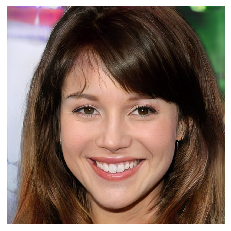

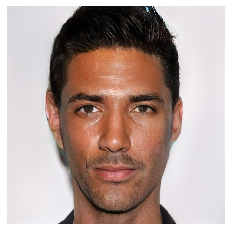

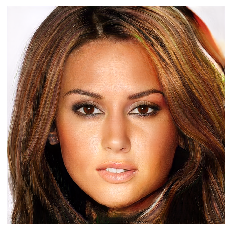

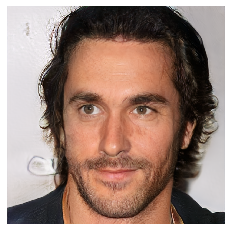

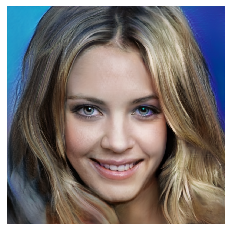

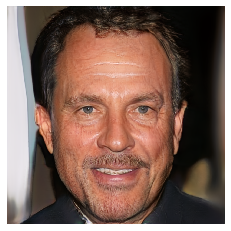

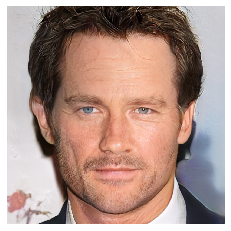

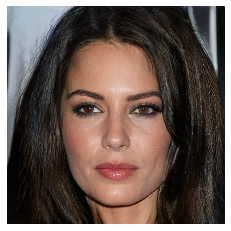

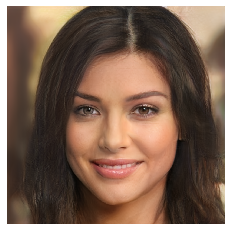

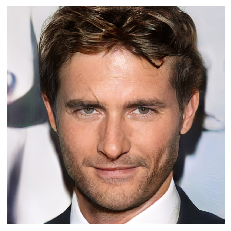

In [0]:
def getDefaultLatents(inputShape):
    """
    Returns the handpicked latent vectors.
    """
    latents = np.random.RandomState(1000).randn(1000, inputShape)
    latents = latents[[477, 56, 83, 887, 583, 391, 86, 340, 341, 415]]
    return latents

# Get the latent vectors and run them through the generator
latents = getDefaultLatents(*Gs.input_shapes[0][1:])
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

# This is the part where latent vectors are turned into images by the generator
images = Gs.run(latents, labels)

# Convert images to PIL-compatible format.
images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

# Save images as PNG.
for idx in range(images.shape[0]):
    PIL.Image.fromarray(images[idx], 'RGB').save('img%d.png' % idx)

# Load the images and display them
for idx in range(images.shape[0]):
    img = mpimg.imread(f"img{idx}.png")
    plt.axis('off')
    plt.imshow(img)
    plt.show()

So these images look pretty good, but we can go a step further by trying to interpolate between two latent vectors, and then ploting the outputs that are generated at the points between these vectors.

Below I've defined a function which given two vectors, will return the vectors inbetween at regular intervals. The numVectors variable specifies how many vectors should be returned.

In [0]:
def _interpolate(A, B, numVectors):

    assert len(A.shape) == 1
    assert len(B.shape) == 1

    latents = [np.copy(A)]
    
    # Calculate the difference between each sample
    latentDiff = (B - A) / (numVectors + 1)
    
    # Apply the diff
    for idx in range(numVectors):
        thisLatent = np.copy(latents[-1])
        thisLatent = thisLatent + latentDiff
        
        # Add this latent to the list
        thisLatent = np.expand_dims(thisLatent, axis=0)
        latents = np.concatenate((latents, thisLatent), axis=0)
        
    # Add B to the end
    latents = np.concatenate((latents, np.expand_dims(B, axis=0)), axis=0)

    return latents

We can then run the model again in exactly the same way, but using the latent vectors that were created by sampling between two handpicked latent vectors.

The below code will handpick two latent vectors, and then produce a series of images created by points inbetween them at regular intervals.

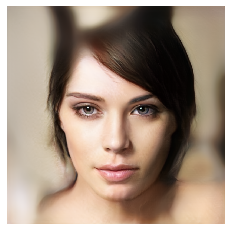

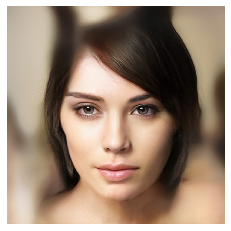

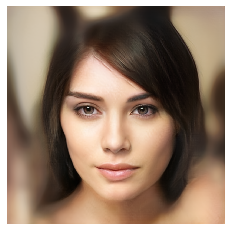

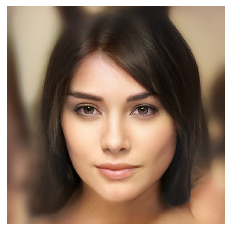

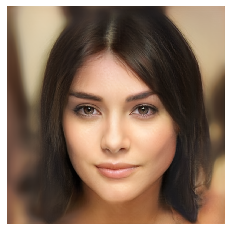

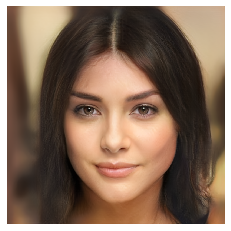

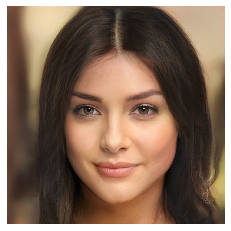

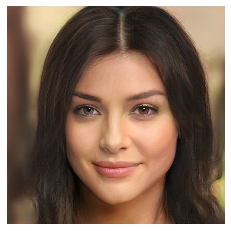

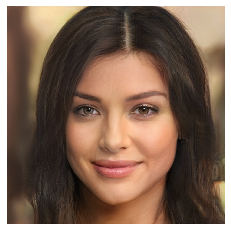

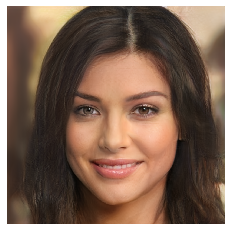

In [0]:
def getInterLatents(inputShape):
    latents = np.random.RandomState(1000).randn(1000, inputShape)
    latents = _interpolate(latents[66], latents[341], 8)
    
    return latents

latents = getInterLatents(*Gs.input_shapes[0][1:])

labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
images = Gs.run(latents, labels)

# Convert images to PIL-compatible format.
images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

# Save images as PNG.
for idx in range(images.shape[0]):
    PIL.Image.fromarray(images[idx], 'RGB').save('img%d.png' % idx)

# Load the images and display them
for idx in range(images.shape[0]):
    img = mpimg.imread(f"img{idx}.png")
    plt.axis('off')
    plt.imshow(img)
    plt.show()


In [0]:
# Close the interactive session when we're done
sess.close()

Finally, it may be useful to save these images into a single file.

In [0]:
def combineImages(imageNames):
    
    images = list()
    for imageName in imageNames:
        images.append(Image.open(imageName))
    
    widths, heights = zip(*(i.size for i in images))
    
    print(f"Combining {len(widths)} images")

    totalWidth = sum(widths)
    maxHeight = max(heights)

    new_im = Image.new("RGB", (totalWidth, maxHeight))
    
    Xoffset = 0
    for im in images:
      new_im.paste(im, (Xoffset, 0))
      Xoffset += im.size[0]
        
    return new_im

combineImages(["img0.png", "img1.png", "img2.png", "img3.png", "img4.png", "img5.png", "img6.png", "img7.png", "img8.png", "img9.png"]).save("combine.png")

Combining 10 images


This notebook was just a basic introduction to generating images with ProGAN using colab, but by modifying the above examples you should now be able to run your own experiments and further explore the latent space of the pretrained ProGAN models.

There's much more you can do using ProGAN and this was really just a quick demonstration, I recommend checking out the ProGAN repo for more resources:

https://github.com/tkarras/progressive_growing_of_gans